In [1]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""

import arpes.config

arpes.config.DOCS_BUILD = True

Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2024-02-01_11-00-20.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


# An Example XPS Analysis

In this example analysis, we are going to look at how some elements of PyARPES fit together. We'll use the `example_data.nano_xps` dataset.

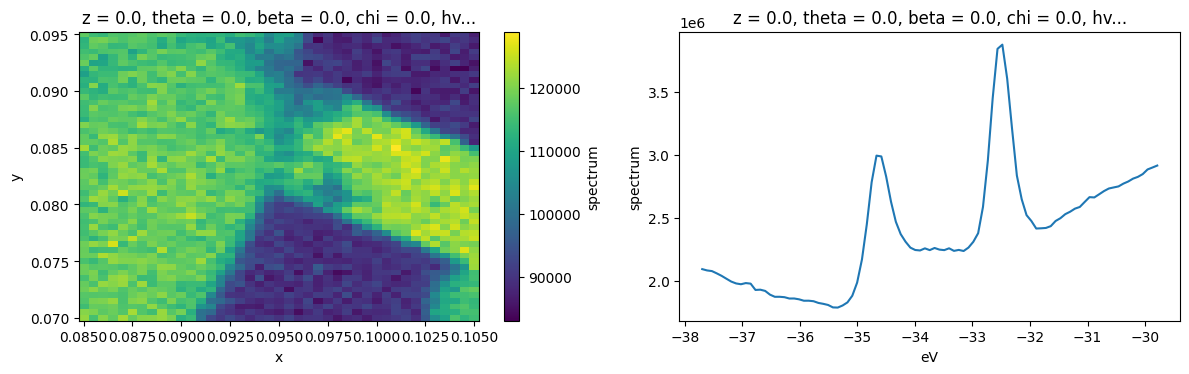

In [2]:
from arpes.io import example_data
import matplotlib.pyplot as plt

xps = example_data.nano_xps

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
xps.sum("eV").S.plot(ax=axes[0])
xps.sum(["x", "y"]).S.plot(ax=axes[1])
plt.tight_layout()

## Decomposition Analysis

Let's look at this XPS data by performing a PCA-based decomposition across the spatial axes. This, in combination with manual exploration, will give us some sense of what's going on across the sample surface.

In [3]:
from arpes.analysis.decomposition import pca_along
import xarray as xr

n_components = 5
data, pca = pca_along(xps, ["x", "y"], n_components=n_components)

/Users/arafune/src/arpes/arpes/analysis/decomposition.py:114: UserWarning: Parent array has no ID.
  provenance(into, data, provenance_context)


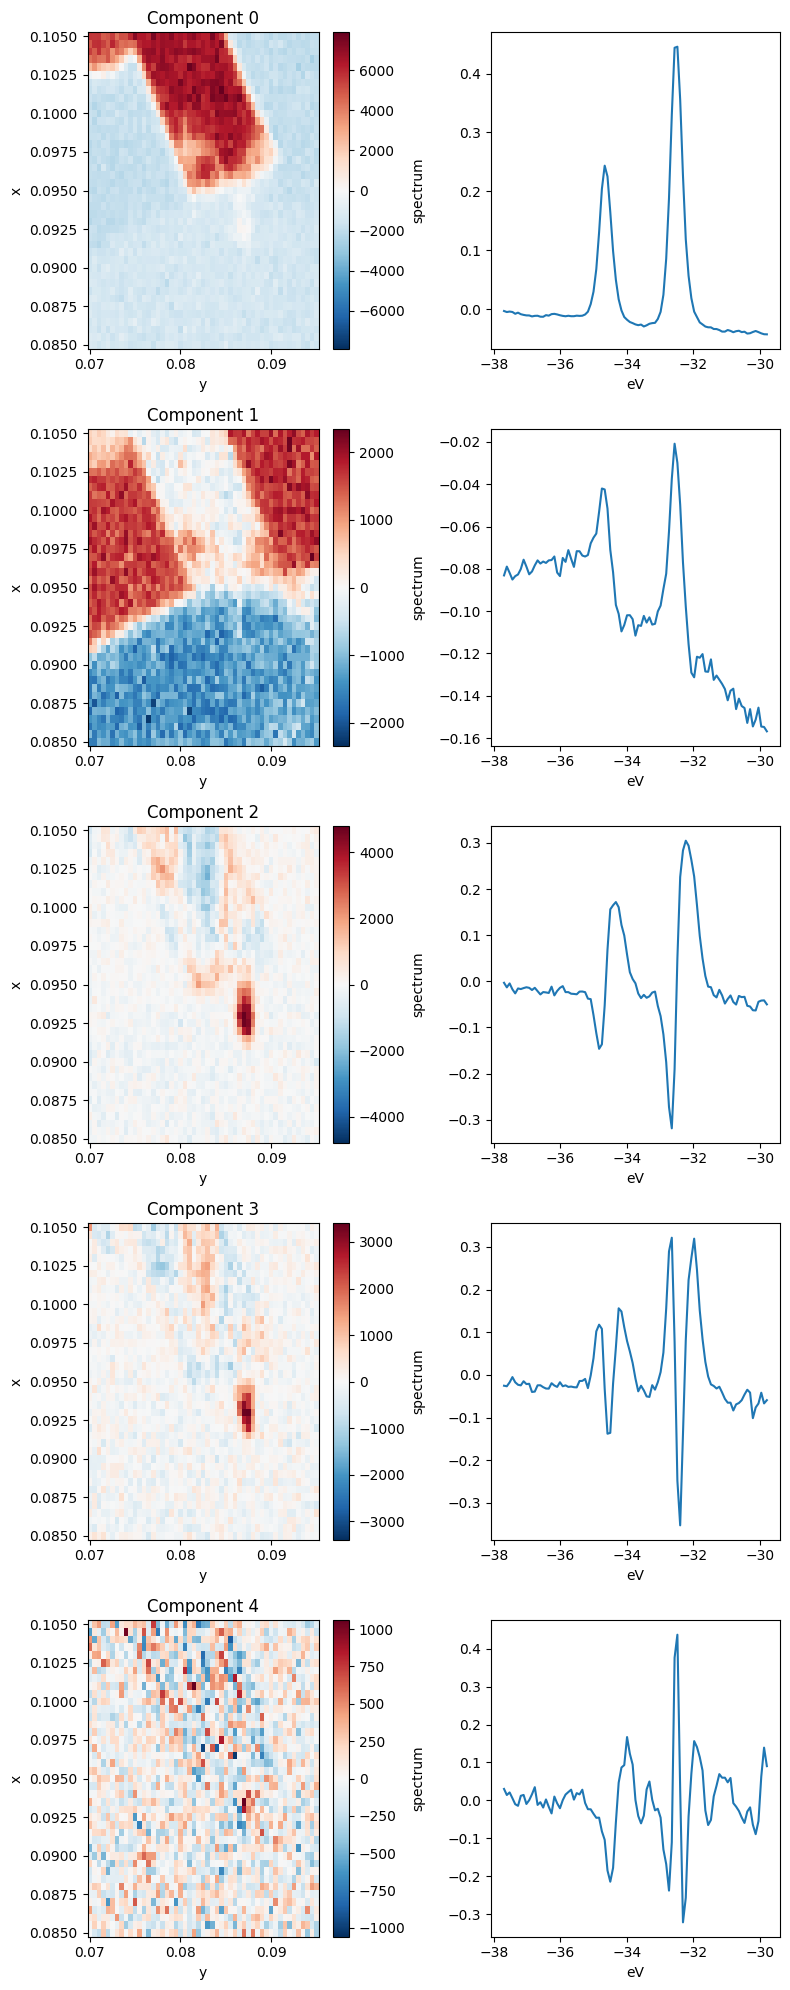

In [4]:
fig, ax = plt.subplots(n_components, 2, figsize=(8, 4 * n_components))

for component in range(n_components):
    data.isel(components=component).S.plot(ax=ax[component, 0])
    ax[component, 0].set_title(f"Component {component}")

    xr.DataArray(pca.components_[component], {"eV": xps.eV.values}, ["eV"]).plot(
        ax=ax[component, 1]
    )

plt.tight_layout()

Let's parse this. Each row above has a spatial map of the coefficient in the decomposition (left) and the XPS spectrum corresponding to that component (right). Very intense locations in the spatial maps correspond to places where the spectrum on the right is a good representation to the data (red) or to its negative (blue).

Based on the images, we can see that the first four components (0 through 3) explain almost all the variation in the data.

The first component corresponds to a $\text{WS}_2$ 4f core level spectrum, so regions of high intensity here indicate the presence of $\text{WS}_2$. 

The next component has a wide background, but it still contains the imprint of the core level peaks. What's going on here? Note that in the `Component 0` image, the area surrounding the $\text{WS}_2$ has a negative coefficient, but if we look at the average below, corresponding to an area to the left of the $\text{WS}_2$ patch, there are no peaks. The decomposition has learned that it needs to add some core-level like peaks back into the data in order to recover these regions. Clearly, this is not an ideal decomposition, and it points to the need to interpret your analysis. There are other decompositions we could perform which have better biases for spectroscopic data.

Moving to the third component we see some internal structure on the $\text{WS}_2$ sample. By looking at the corresponding PCA component, this appears to represent a core level shift toward lower binding energy.

The fourth and final component we will interpret (`Component 3`) again explains internal structure on the $\text{WS}_2$. Looking at the corresponding spectrum, it looks like these regions correspond to wider core levels as measured by photoemission.

### Selecting data using the PCA decomposition

Suppose we want to continue analysis using only the core levels for the $\text{WS}_2$ region, as identified by `Component 0`. We can do this by masking and selecting the data before averaging.

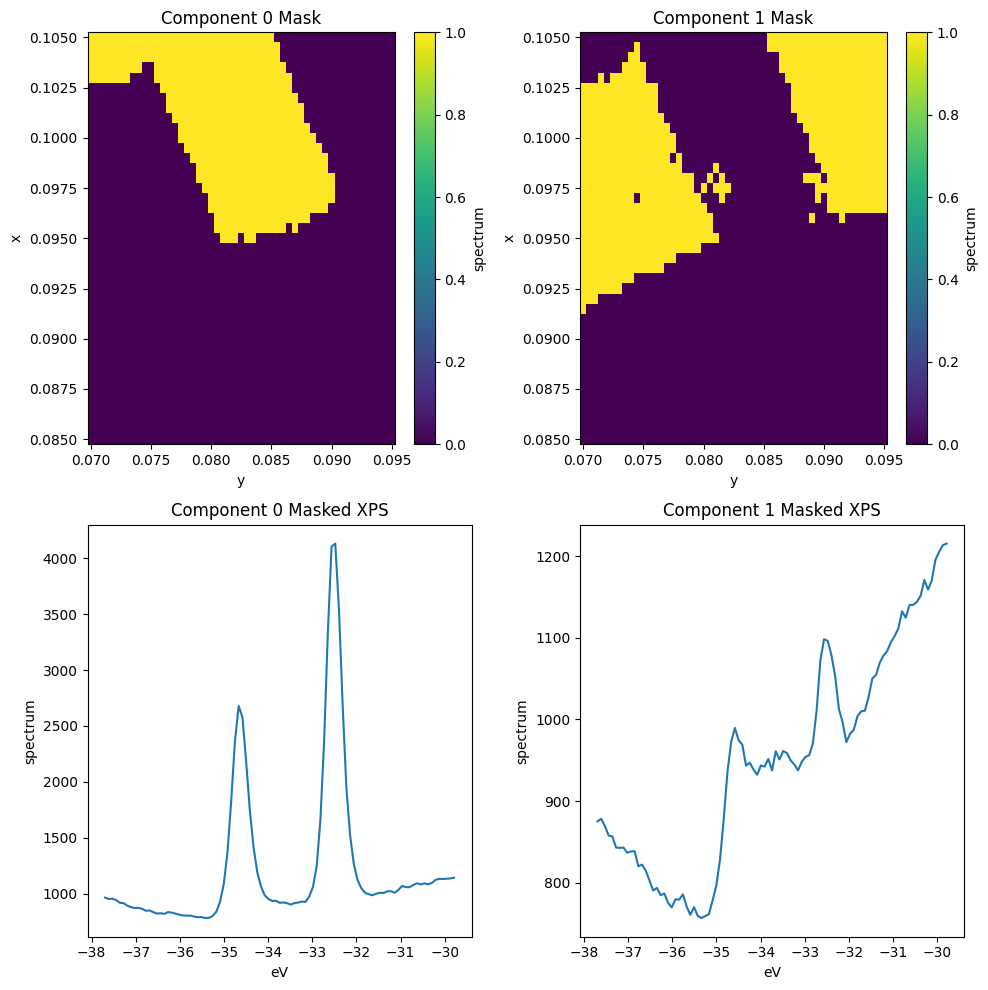

In [5]:
ws2_mask = data.isel(components=0) > 500
substrate_mask = data.isel(components=1) > 1000

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ws2_mask.S.plot(ax=ax[0, 0])
substrate_mask.S.plot(ax=ax[0, 1])

xps.spectrum.where(ws2_mask).mean(["x", "y"]).S.plot(ax=ax[1, 0])
xps.spectrum.where(substrate_mask).mean(["x", "y"]).S.plot(ax=ax[1, 1])

ax[0, 0].set_title("Component 0 Mask")
ax[0, 1].set_title("Component 1 Mask")
ax[1, 0].set_title("Component 0 Masked XPS")
ax[1, 1].set_title("Component 1 Masked XPS")

plt.tight_layout()

### Improving our masks

We can see there's still some $\text{WS}_2$ contamination in the `substrate_mask`. We can improve this by masking according to both of the first two components.

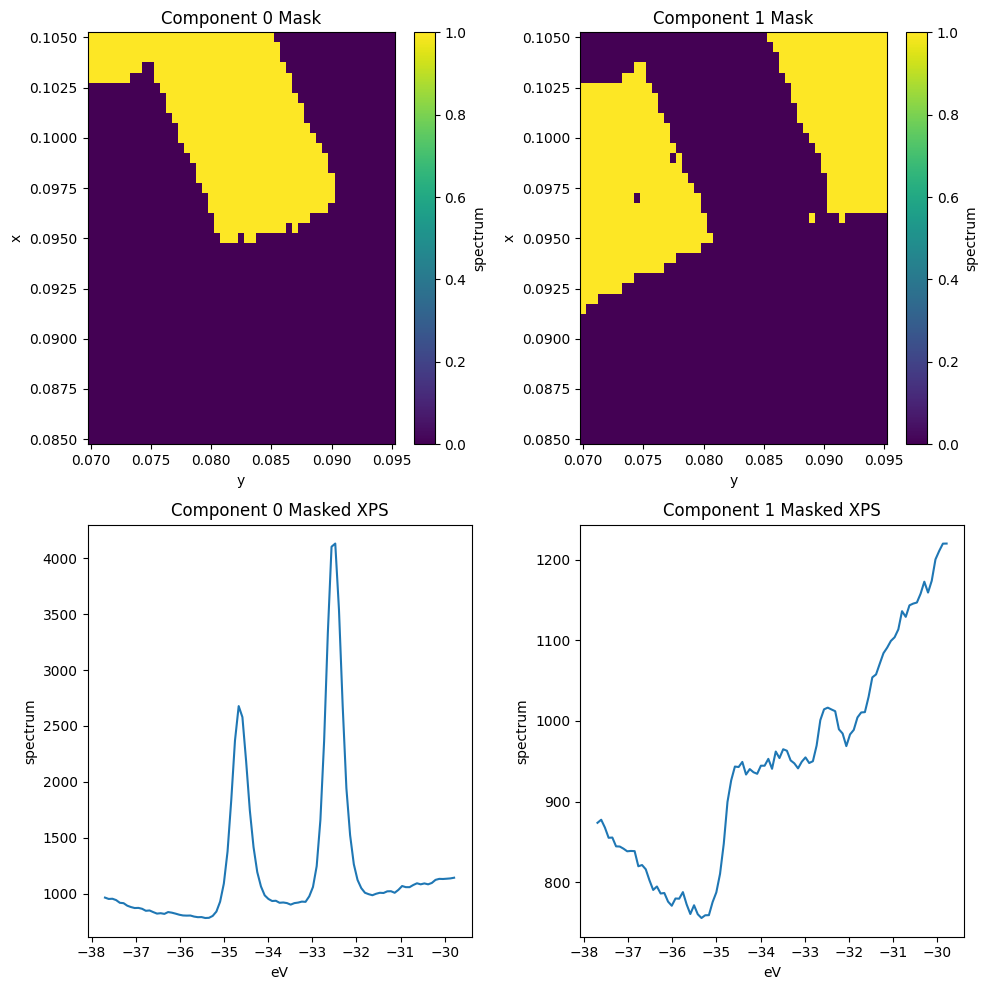

In [6]:
ws2_mask = data.isel(components=0) > 500
substrate_mask = (data.isel(components=1) > 1000) & ~ws2_mask

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ws2_mask.S.plot(ax=ax[0, 0])
substrate_mask.S.plot(ax=ax[0, 1])

xps.spectrum.where(ws2_mask).mean(["x", "y"]).S.plot(ax=ax[1, 0])
xps.spectrum.where(substrate_mask).mean(["x", "y"]).S.plot(ax=ax[1, 1])

ax[0, 0].set_title("Component 0 Mask")
ax[0, 1].set_title("Component 1 Mask")
ax[1, 0].set_title("Component 0 Masked XPS")
ax[1, 1].set_title("Component 1 Masked XPS")

plt.tight_layout()

### Looking at the wider vs narrower peak regions

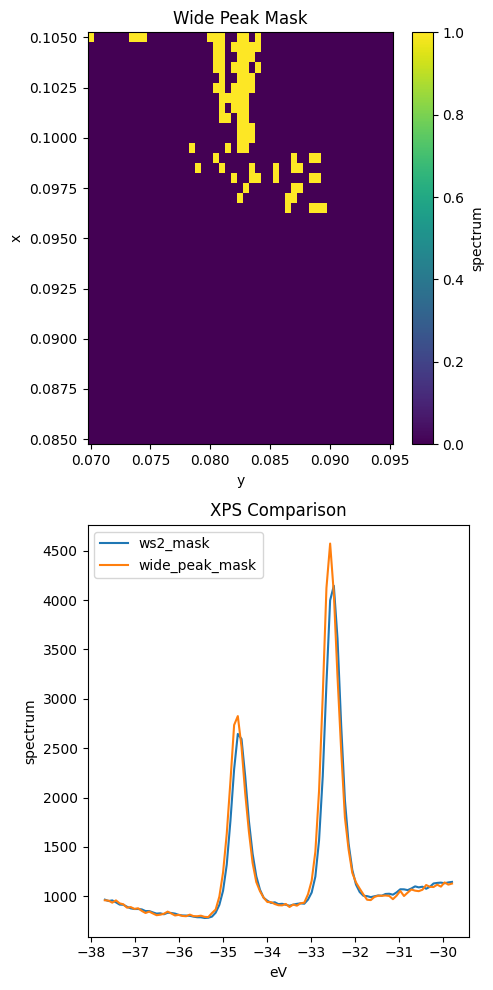

In [7]:
from arpes.config import use_tex

use_tex(rc_text_should_use=False)

ws2_mask = data.isel(components=0) > 500
wide_peak_mask = (data.isel(components=3) > 500) & ws2_mask

fig, ax = plt.subplots(2, 1, figsize=(5, 10))
wide_peak_mask.S.plot(ax=ax[0])

xps.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).S.plot(ax=ax[1], label="ws2_mask")
xps.spectrum.where(wide_peak_mask).mean(["x", "y"]).S.plot(ax=ax[1], label="wide_peak_mask")

ax[1].legend()

ax[0].set_title("Wide Peak Mask")
ax[1].set_title("XPS Comparison")

plt.tight_layout()

These peaks look very similar, but sure enough the ones captured by `wide_peak_mask` are wider, especially to high binding energy.

Let's look at refining this analysis now with some curve fitting.

## Curve Fitting

First off, let's get a general model working using a single XPS curve.

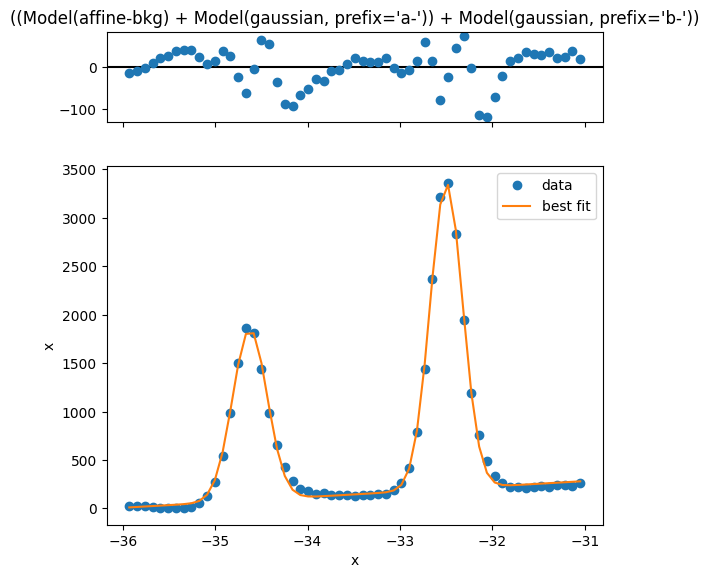

In [8]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel

test_curve = xps.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

test_model = AffineBackgroundModel() + GaussianModel(prefix="a_") + GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": -34.6},
        "b_center": {"value": -32.5},
    },
)
result.plot()
result

This looks reasonably good, but we can improve the simplicity and quality of the model if we just remove an estimated background first. Let's see how that looks

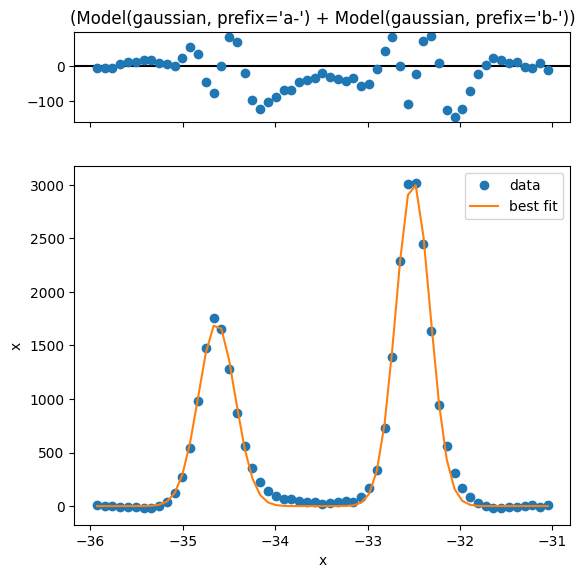

In [9]:
from arpes.fits.fit_models import GaussianModel
from arpes.analysis.shirley import remove_shirley_background
from arpes.fits.utilities import result_to_hints

mask = ws2_mask | (data.isel(components=3) > 800)
test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
test_curve = remove_shirley_background(test_curve)

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve,
    params={
        "a_center": {"value": -34.6},
        "b_center": {"value": -32.5},
    },
)
result.plot()
result

Looking at the residual this is quite a bit better. Now let's perform fitting across the entire $\text{WS}_2$ region.

In [10]:
from arpes.fits.utilities import broadcast_model

# subtract the Shirley background, calculated independently at each (x,y)
bkg_removed_xps = remove_shirley_background(xps.sel(eV=slice(-36, -31)))

# first mask
masked_xps = bkg_removed_xps.where(mask)

In [11]:
# Performs ~500 curve fits... make a selection if you don't want to wait a few seconds
results = broadcast_model(
    [GaussianModel, GaussianModel],
    masked_xps.fillna(0),   # <- fillna is essentially required.
    ["x", "y"],
    params=result_to_hints(result),  # use our single curve fit above for initial parameter
)

Fitting on pool...:   0%|          | 0/2091 [00:00<?, ?it/s]

### Interepting the fit quality

Let's have a look at the five worst fits now.

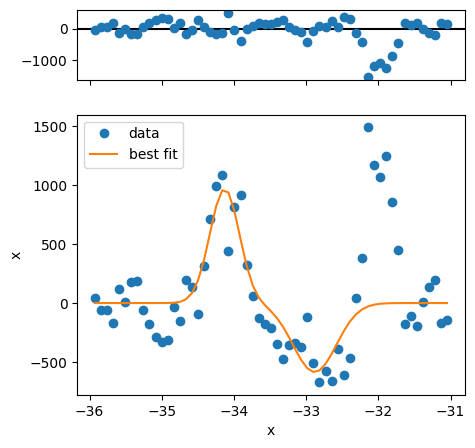

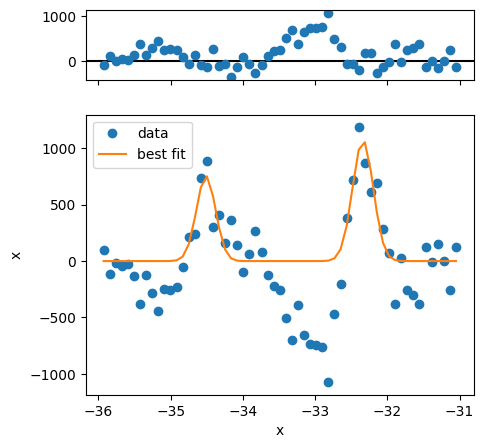

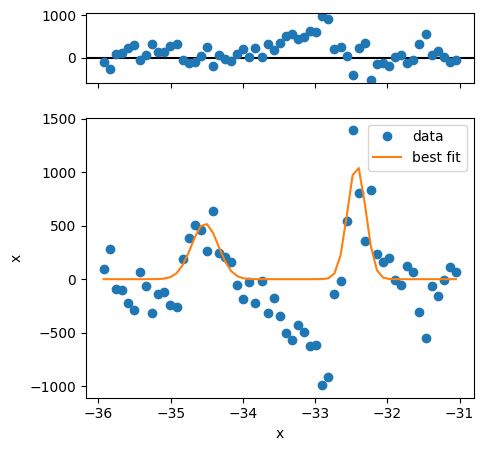

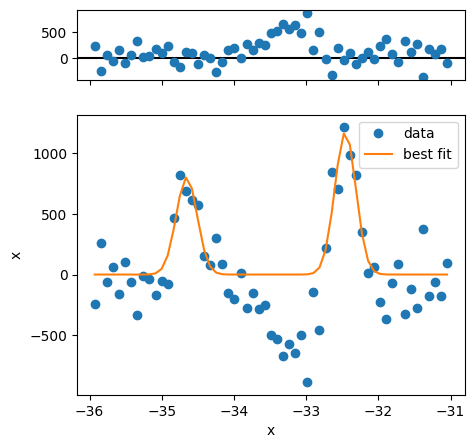

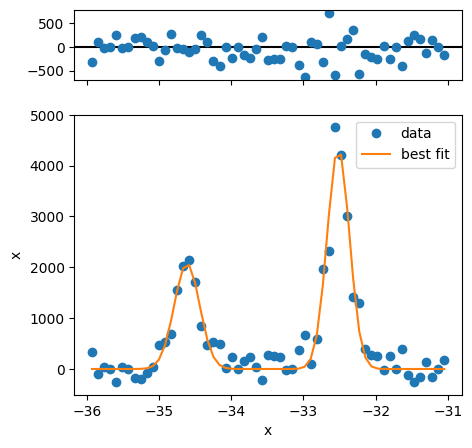

In [12]:
worst = results.F.worst_fits().values

for i in range(5):
    fig = plt.figure(figsize=(5, 5))
    worst[i].plot(fig=fig)
    for ax in fig.axes:
        ax.set_title("")

The first three fits have quality issues, because the background looks not to be appropriately captured and the peak shape is different from the rest. Three problematic fits out of several hundred is not so bad, so we can continue.

For proper analysis you might want to exclude these points.

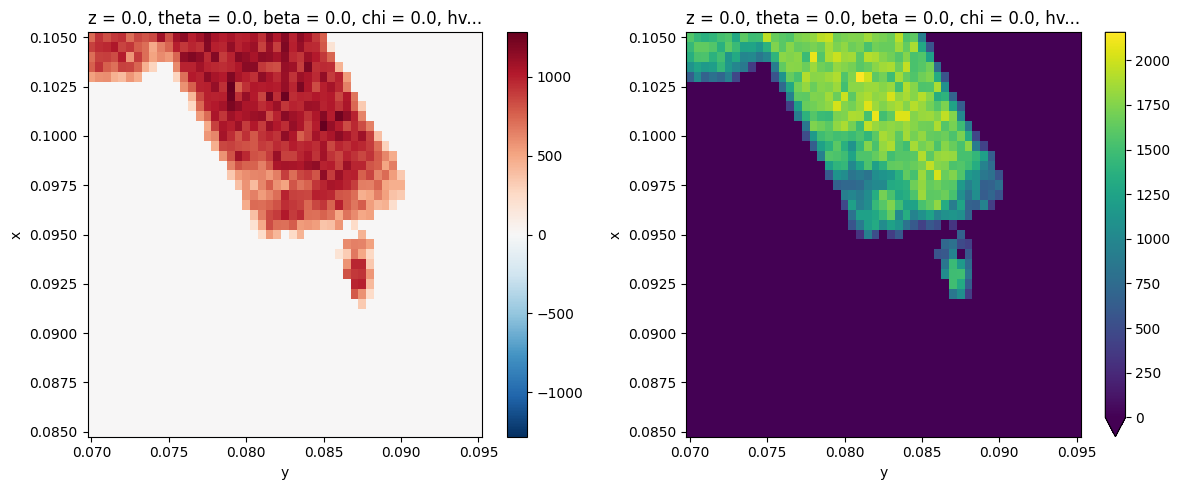

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
results.F.p("a_amplitude").T.S.plot(ax=ax[0])
results.F.p("b_amplitude").T.S.plot(ax=ax[1], vmin=0)
plt.tight_layout()

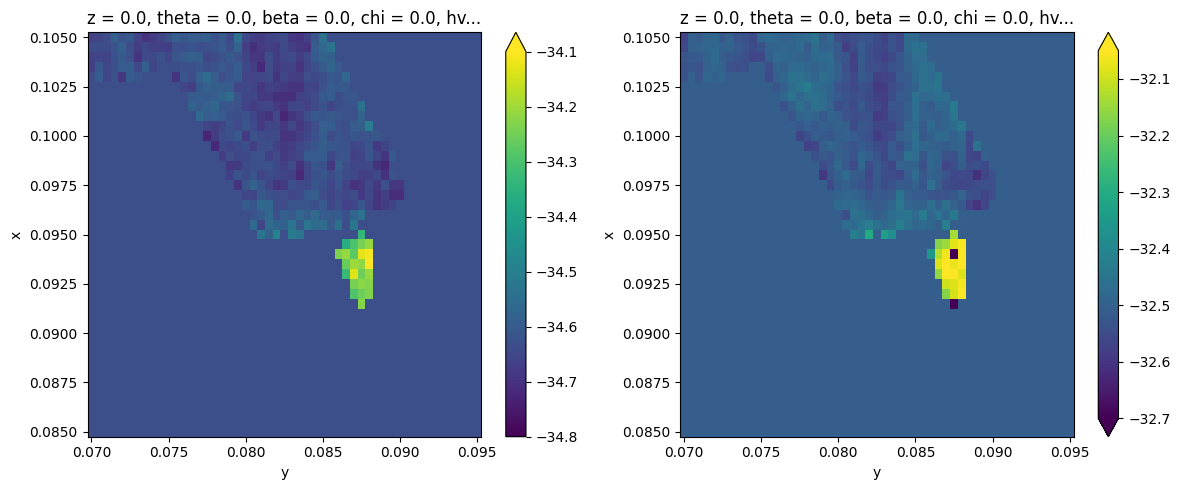

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
results.F.p("a_center").T.S.plot(ax=ax[0], vmin=-34.8, vmax=-34.1)
results.F.p("b_center").T.S.plot(ax=ax[1], vmin=-32.7, vmax=-32.05)
plt.tight_layout()

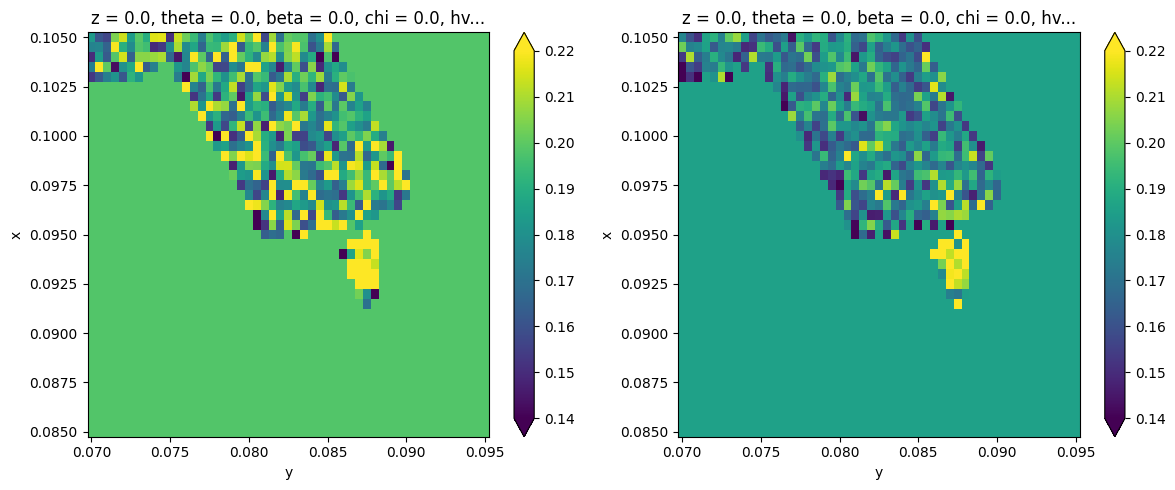

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
results.F.p("a_sigma").T.S.plot(ax=ax[0], vmax=0.22, vmin=0.14)
results.F.p("b_sigma").T.S.plot(ax=ax[1], vmax=0.22, vmin=0.14)
plt.tight_layout()

(0.0, 2400.0)

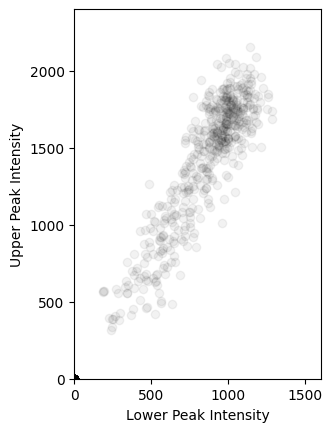

In [16]:
plt.scatter(
    results.F.p("a_amplitude").values.ravel(),
    results.F.p("b_amplitude").values.ravel(),
    color=(0, 0, 0, 0.05),
)
plt.gca().set_aspect(1)
plt.gca().set_xlabel("Lower Peak Intensity")
plt.gca().set_ylabel("Upper Peak Intensity")
plt.gca().set_xlim([0, 1600])
plt.gca().set_ylim([0, 2400])

Text(0, 0.5, 'Upper Peak BE')

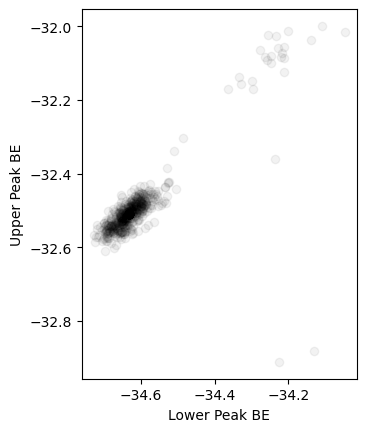

In [17]:
plt.scatter(
    results.F.p("a_center").values.ravel(),
    results.F.p("b_center").values.ravel(),
    color=(0, 0, 0, 0.05),
)
plt.gca().set_aspect(1)
plt.gca().set_xlabel("Lower Peak BE")
plt.gca().set_ylabel("Upper Peak BE")

Text(0, 0.5, 'Upper Peak Width')

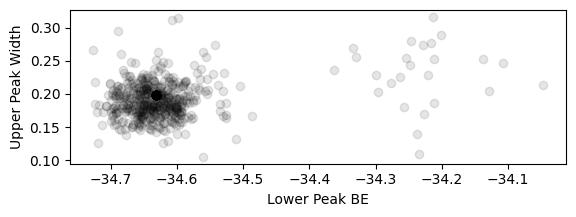

In [18]:
plt.scatter(
    results.F.p("a_center").values.ravel(),
    results.F.p("a_sigma").values.ravel(),
    color=(0, 0, 0, 0.1),
)
plt.gca().set_aspect(1)
plt.gca().set_xlabel("Lower Peak BE")
plt.gca().set_ylabel("Upper Peak Width")

The two cohorts in each of the above plots are the piece of $\text{WS}_2$ on substrate and on plain Si respectively, confirming earlier expectations from the PCA analysis.

## Exercises

1. Peform a selection of the data according to the fitting values and plot the corresponding mask. What does the collection of points for which **Lower Peak BE** > -34.4eV look like?
2. Peform a selection of the data for the decompositions above and plot their corresponding average XPS curves. How do these results compare to the PCA results we found before?
3. What might you conclude about the sample and experimental conditions given the extracted peak width map?